https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-simpsons-paradox.html

Simpson’s Paradox describes a situation where there might be a negative relationship between two variables within a group, but when data from multiple groups are combined, that relationship may disappear or even reverse sign. 

In [12]:
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
figsize = [12, 4]
plt.rcParams["figure.figsize"] = figsize
rng = np.random.default_rng(32)
np.random.seed(32)

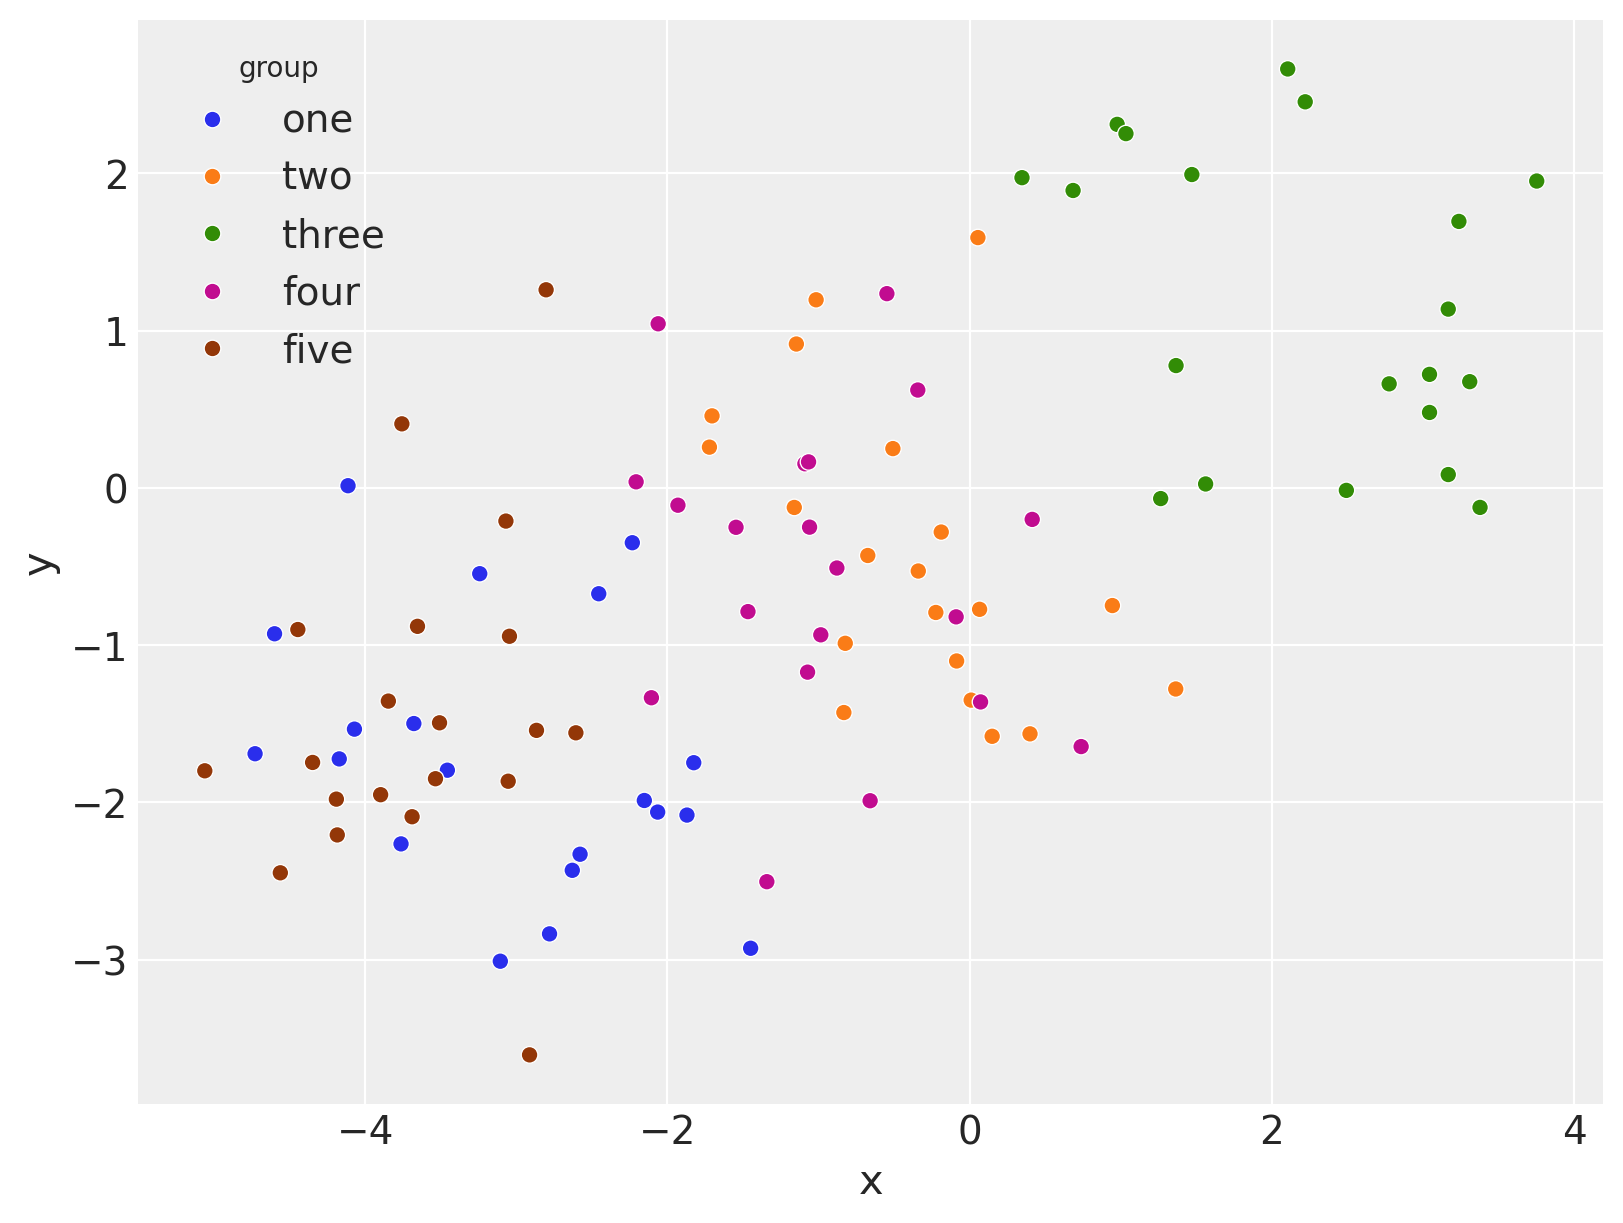

In [15]:
def generate():
    group_list = ["one", "two", "three", "four", "five"]
    trials_per_group = 20
    group_intercepts = rng.normal(0, 1, len(group_list))
    group_slopes = np.ones(len(group_list)) * -0.5
    group_mx = group_intercepts * 2
    group = np.repeat(group_list, trials_per_group)
    subject = np.concatenate(
        [np.ones(trials_per_group) * i for i in np.arange(len(group_list))]
    ).astype(int)
    intercept = np.repeat(group_intercepts, trials_per_group)
    slope = np.repeat(group_slopes, trials_per_group)
    mx = np.repeat(group_mx, trials_per_group)
    x = rng.normal(mx, 1)
    y = rng.normal(intercept + (x - mx) * slope, 1)
    data = pd.DataFrame({"group": group, "group_idx": subject, "x": x, "y": y})
    return data, group_list


data, group_list = generate()
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=data, x="x", y="y", hue="group", ax=ax);

In [20]:
# Simple model
 
with pm.Model() as model1:
    β0 = pm.Normal("β0", 0, sigma=5)
    β1 = pm.Normal("β1", 0, sigma=5)
    sigma = pm.Gamma("sigma", 2, 2)
    x = pm.Data("x", data.x, dims="obs_id")
    μ = pm.Deterministic("μ", β0 + β1 * x, dims="obs_id")
    pm.Normal("y", mu=μ, sigma=sigma, observed=data.y, dims="obs_id")

    idata1 = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0, β1, sigma]


c:\Users\LucasAbreu\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


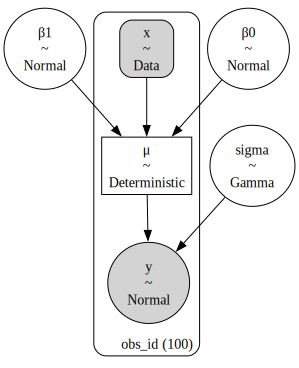

In [19]:
pm.model_to_graphviz(model1)

In [23]:
#Do posterior inference at a set of out of sample points

def predict(model: pm.Model, idata: az.InferenceData, predict_at: dict) -> az.InferenceData:
    
    with model:
        pm.set_data(predict_at)
        idata.extend(pm.sample_posterior_predictive(idata, var_names=["y", "μ"], random_seed=rng))
    return idata

In [24]:
xi = np.linspace(data.x.min(), data.x.max(), 20)

idata1 = predict(
    model=model1,
    idata=idata1,
    predict_at={"x": xi},
)

Sampling: [y]


c:\Users\LucasAbreu\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

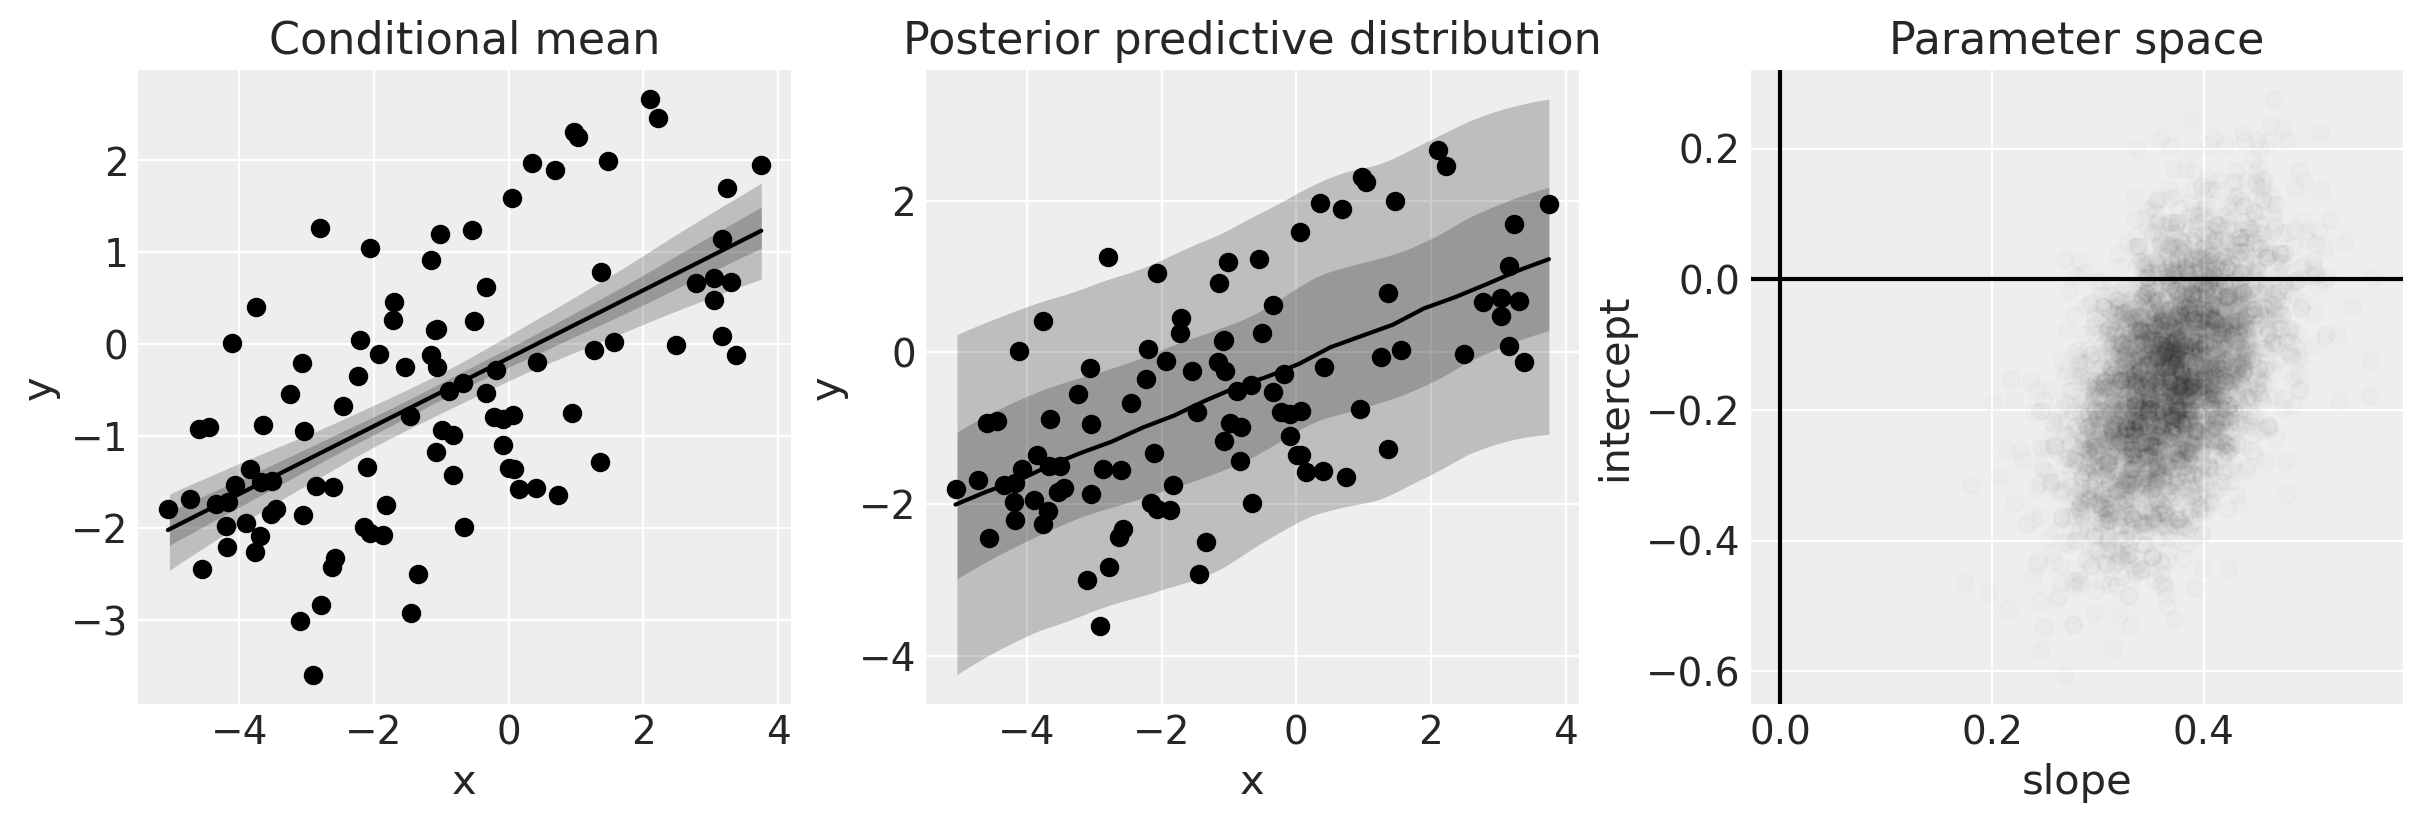

In [25]:
def plot_band(xi, var: xr.DataArray, ax, color: str):
    ax.plot(xi, var.mean(["chain", "draw"]), color=color)

    az.plot_hdi(
        xi,
        var,
        hdi_prob=0.6,
        color=color,
        fill_kwargs={"alpha": 0.2, "linewidth": 0},
        ax=ax,
    )
    az.plot_hdi(
        xi,
        var,
        hdi_prob=0.95,
        color=color,
        fill_kwargs={"alpha": 0.2, "linewidth": 0},
        ax=ax,
    )


def plot(idata: az.InferenceData):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    # conditional mean plot ---------------------------------------------
    ax[0].scatter(data.x, data.y, color="k")
    plot_band(xi, idata.posterior_predictive.μ, ax=ax[0], color="k")
    ax[0].set(xlabel="x", ylabel="y", title="Conditional mean")

    # posterior prediction ----------------------------------------------
    ax[1].scatter(data.x, data.y, color="k")
    plot_band(xi, idata.posterior_predictive.y, ax=ax[1], color="k")
    ax[1].set(xlabel="x", ylabel="y", title="Posterior predictive distribution")

    # parameter space ---------------------------------------------------
    ax[2].scatter(
        az.extract(idata, var_names=["β1"]),
        az.extract(idata, var_names=["β0"]),
        color="k",
        alpha=0.01,
        rasterized=True,
    )

    # formatting
    ax[2].set(xlabel="slope", ylabel="intercept", title="Parameter space")
    ax[2].axhline(y=0, c="k")
    ax[2].axvline(x=0, c="k")


plot(idata1)

In [26]:
# fit independent regressions to data within each group

In [27]:
coords = {"group": group_list}

with pm.Model(coords=coords) as model2:
    # Define priors
    β0 = pm.Normal("β0", 0, sigma=5, dims="group")
    β1 = pm.Normal("β1", 0, sigma=5, dims="group")
    sigma = pm.Gamma("sigma", 2, 2)
    # Data
    x = pm.Data("x", data.x, dims="obs_id")
    g = pm.Data("g", data.group_idx, dims="obs_id")
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma, observed=data.y, dims="obs_id")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0, β1, sigma]


c:\Users\LucasAbreu\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


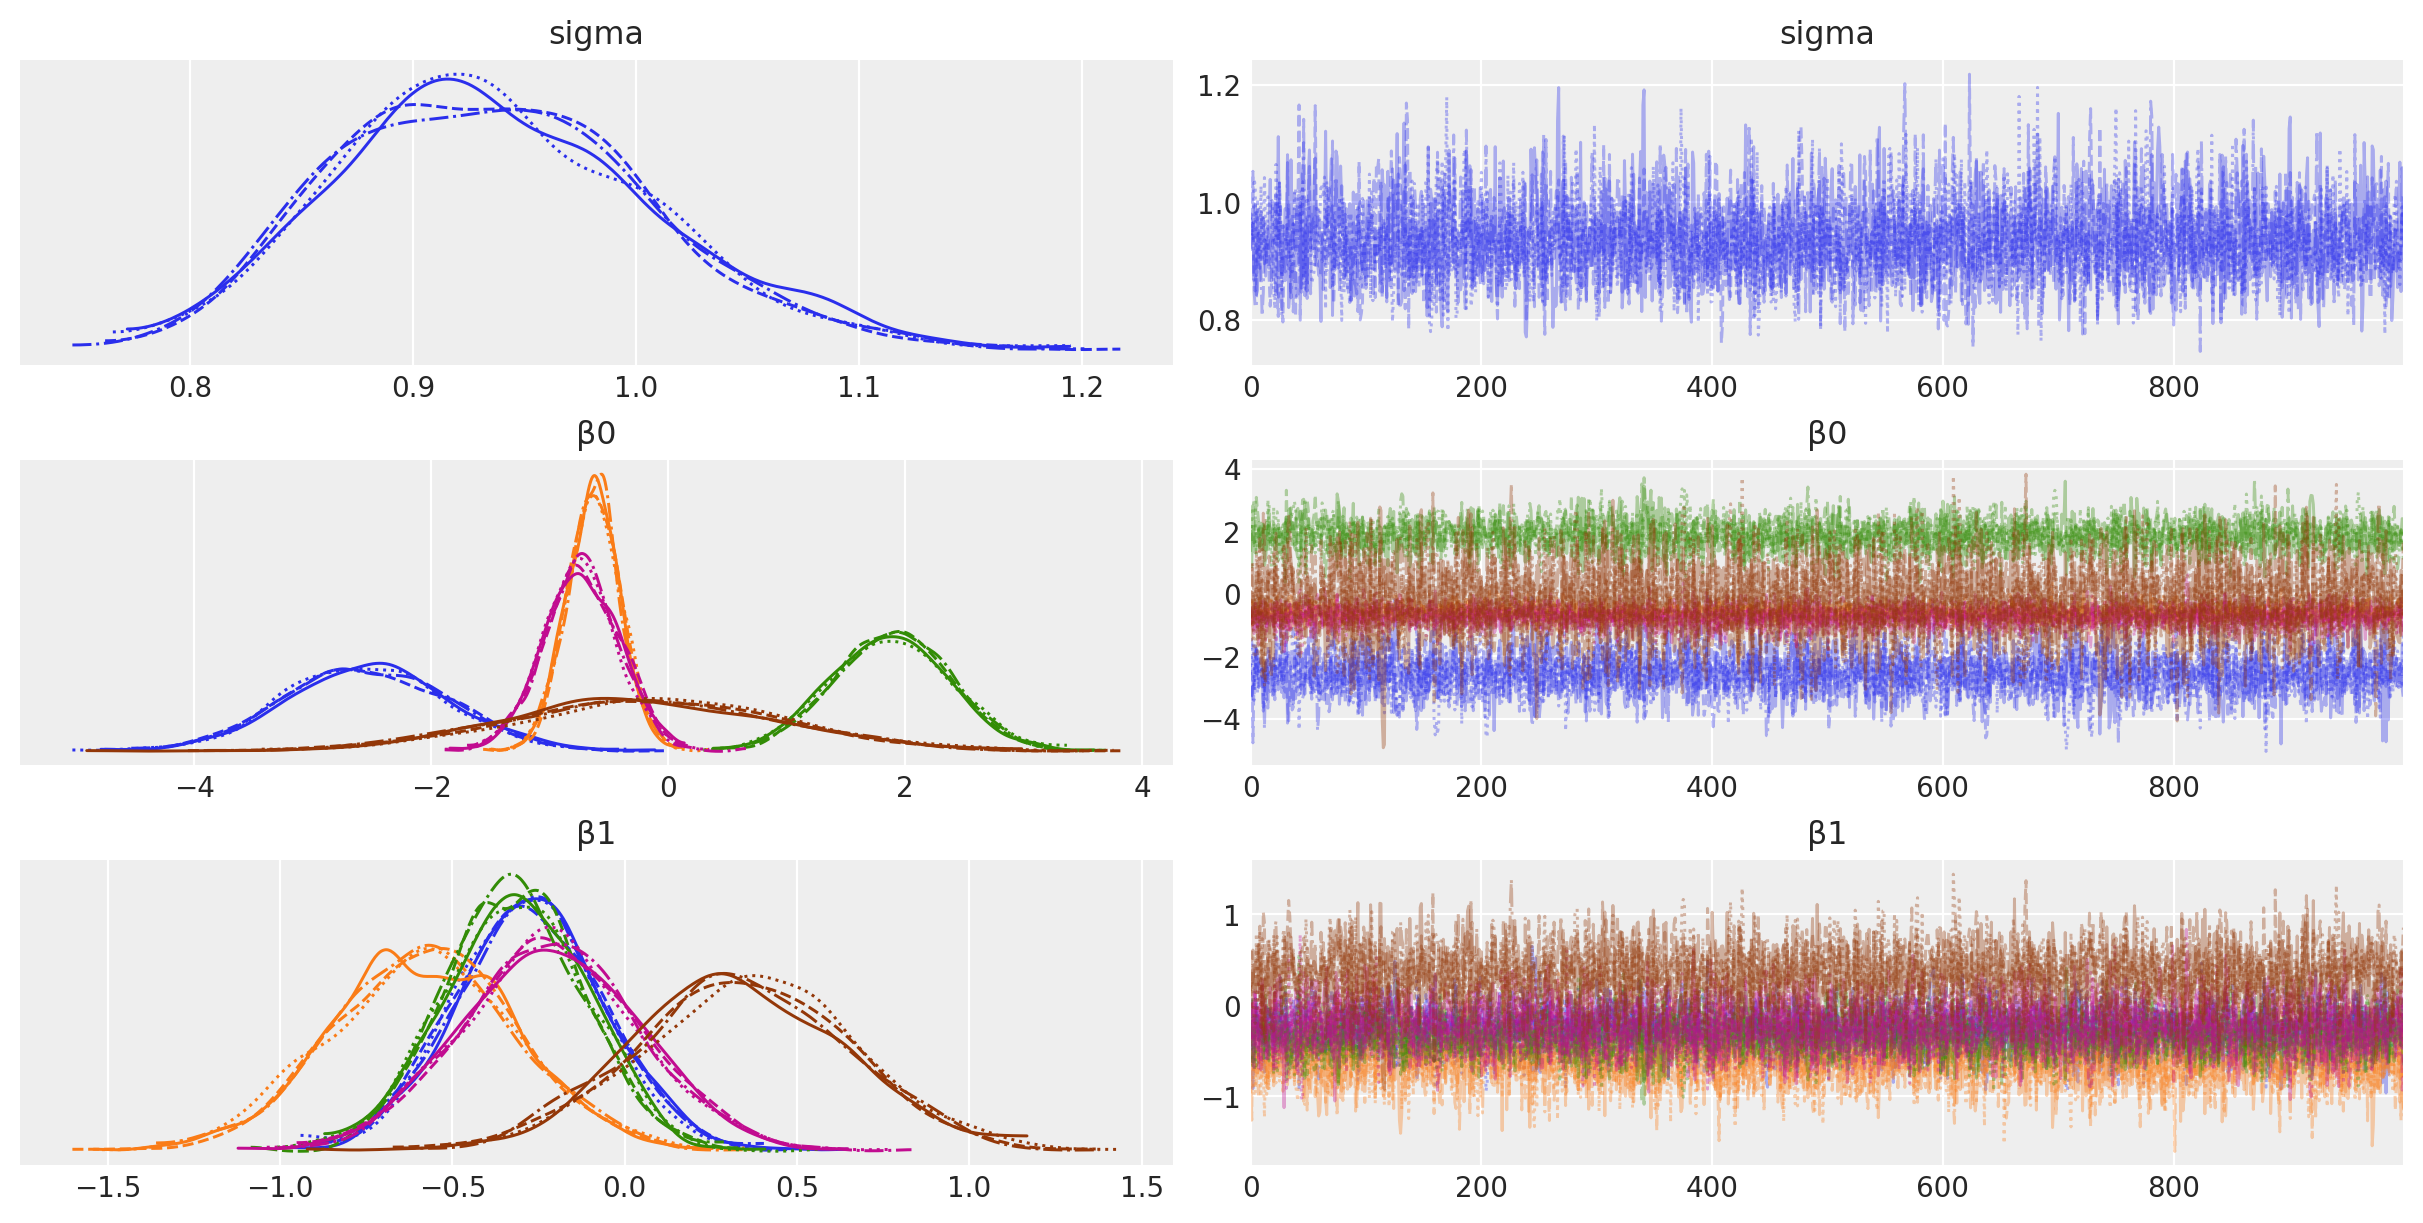

In [30]:
with model2:
    idata2 = pm.sample(random_seed=rng)

az.plot_trace(idata2, var_names=["~μ"]);

In [31]:
# Generate values of xi and g for posterior prediction
n_points = 10
n_groups = len(data.group.unique())
# Generate xi values for each group and concatenate them
xi = np.concatenate(
    [
        np.linspace(group[1].x.min(), group[1].x.max(), n_points)
        for group in data.groupby("group_idx")
    ]
)
# Generate the group indices array g and cast it to integers
g = np.concatenate([[i] * n_points for i in range(n_groups)]).astype(int)
predict_at = {"x": xi, "g": g}

idata2 = predict(
    model=model2,
    idata=idata2,
    predict_at=predict_at,
)

Sampling: [y]


c:\Users\LucasAbreu\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

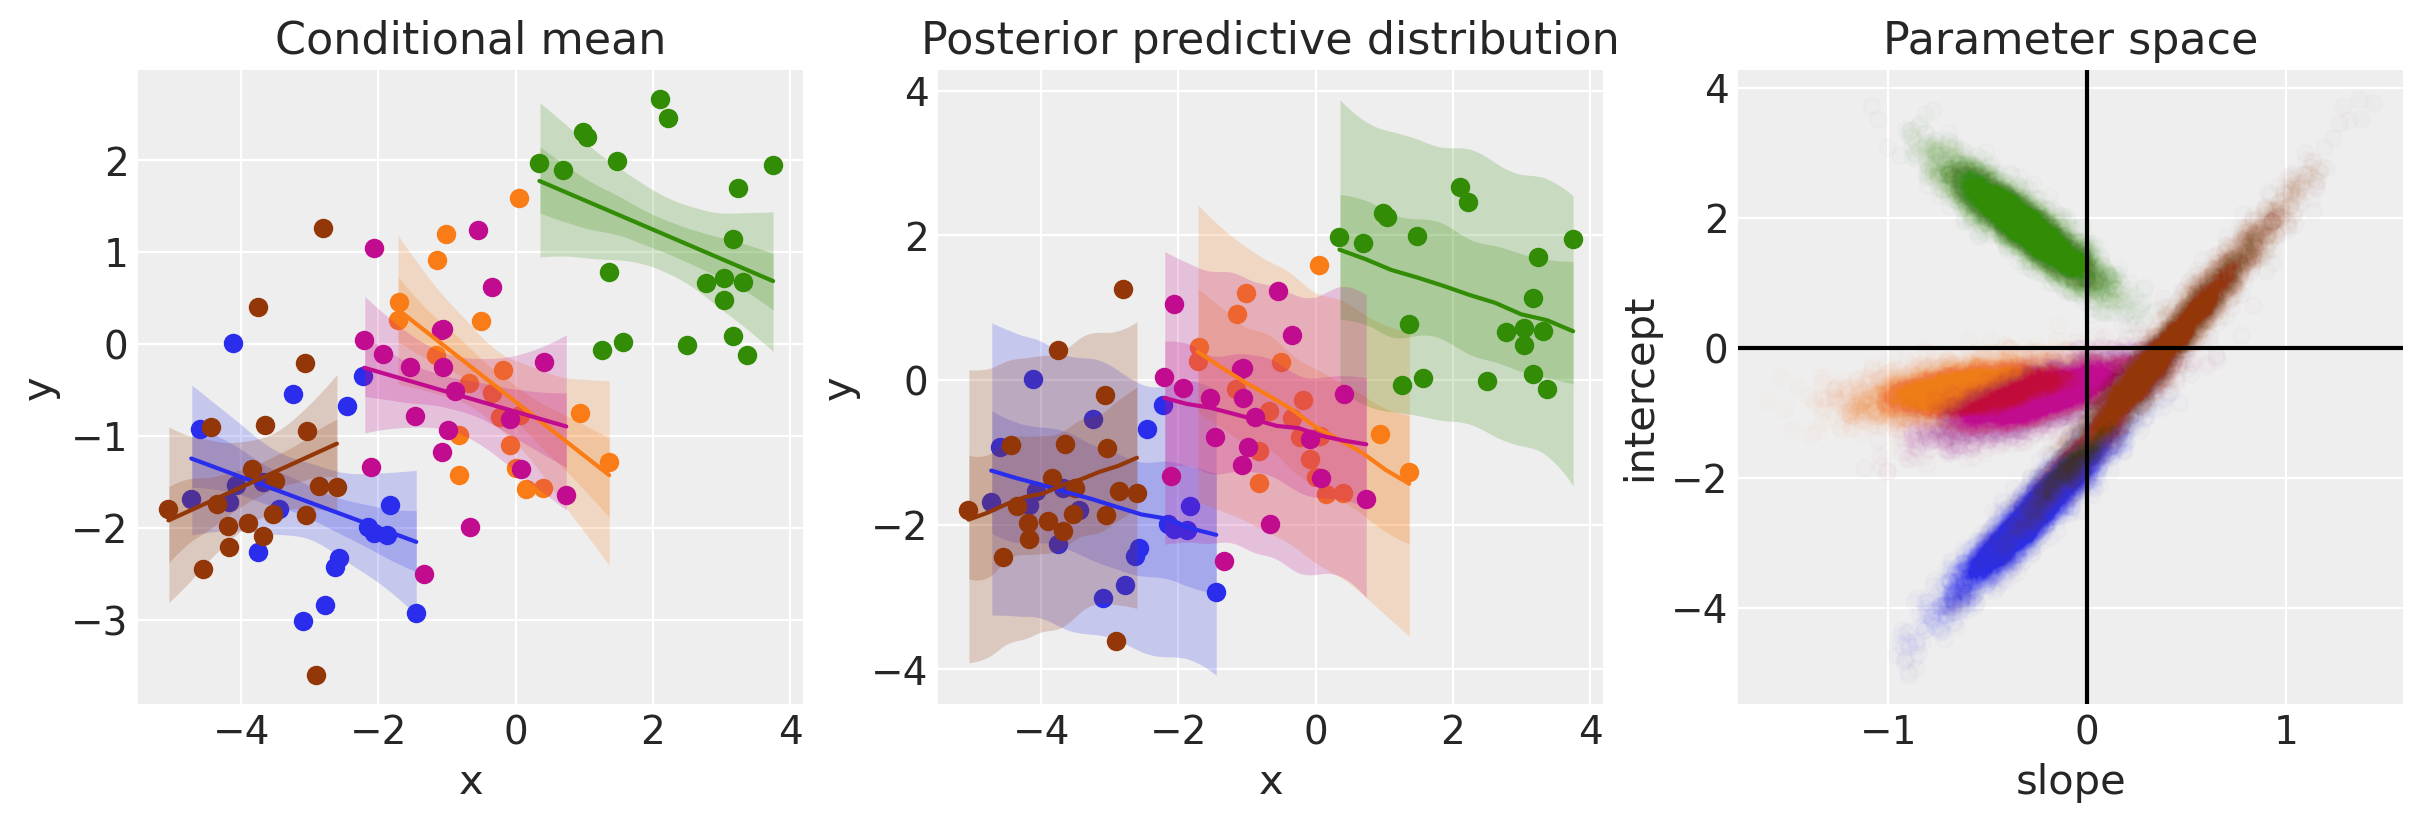

In [34]:
def plot(idata):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    for i in range(len(group_list)):
        # conditional mean plot ---------------------------------------------
        ax[0].scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
        plot_band(
            xi[g == i],
            idata.posterior_predictive.μ.isel(obs_id=(g == i)),
            ax=ax[0],
            color=f"C{i}",
        )

        # posterior prediction ----------------------------------------------
        ax[1].scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
        plot_band(
            xi[g == i],
            idata.posterior_predictive.y.isel(obs_id=(g == i)),
            ax=ax[1],
            color=f"C{i}",
        )

    # formatting
    ax[0].set(xlabel="x", ylabel="y", title="Conditional mean")
    ax[1].set(xlabel="x", ylabel="y", title="Posterior predictive distribution")

    # parameter space ---------------------------------------------------
    for i, _ in enumerate(group_list):
        ax[2].scatter(
            az.extract(idata, var_names="β1")[i, :],
            az.extract(idata, var_names="β0")[i, :],
            color=f"C{i}",
            alpha=0.01,
            rasterized=True,
            zorder=2,
        )

    ax[2].set(xlabel="slope", ylabel="intercept", title="Parameter space")
    ax[2].axhline(y=0, c="k")
    ax[2].axvline(x=0, c="k")
    return ax


plot(idata2);

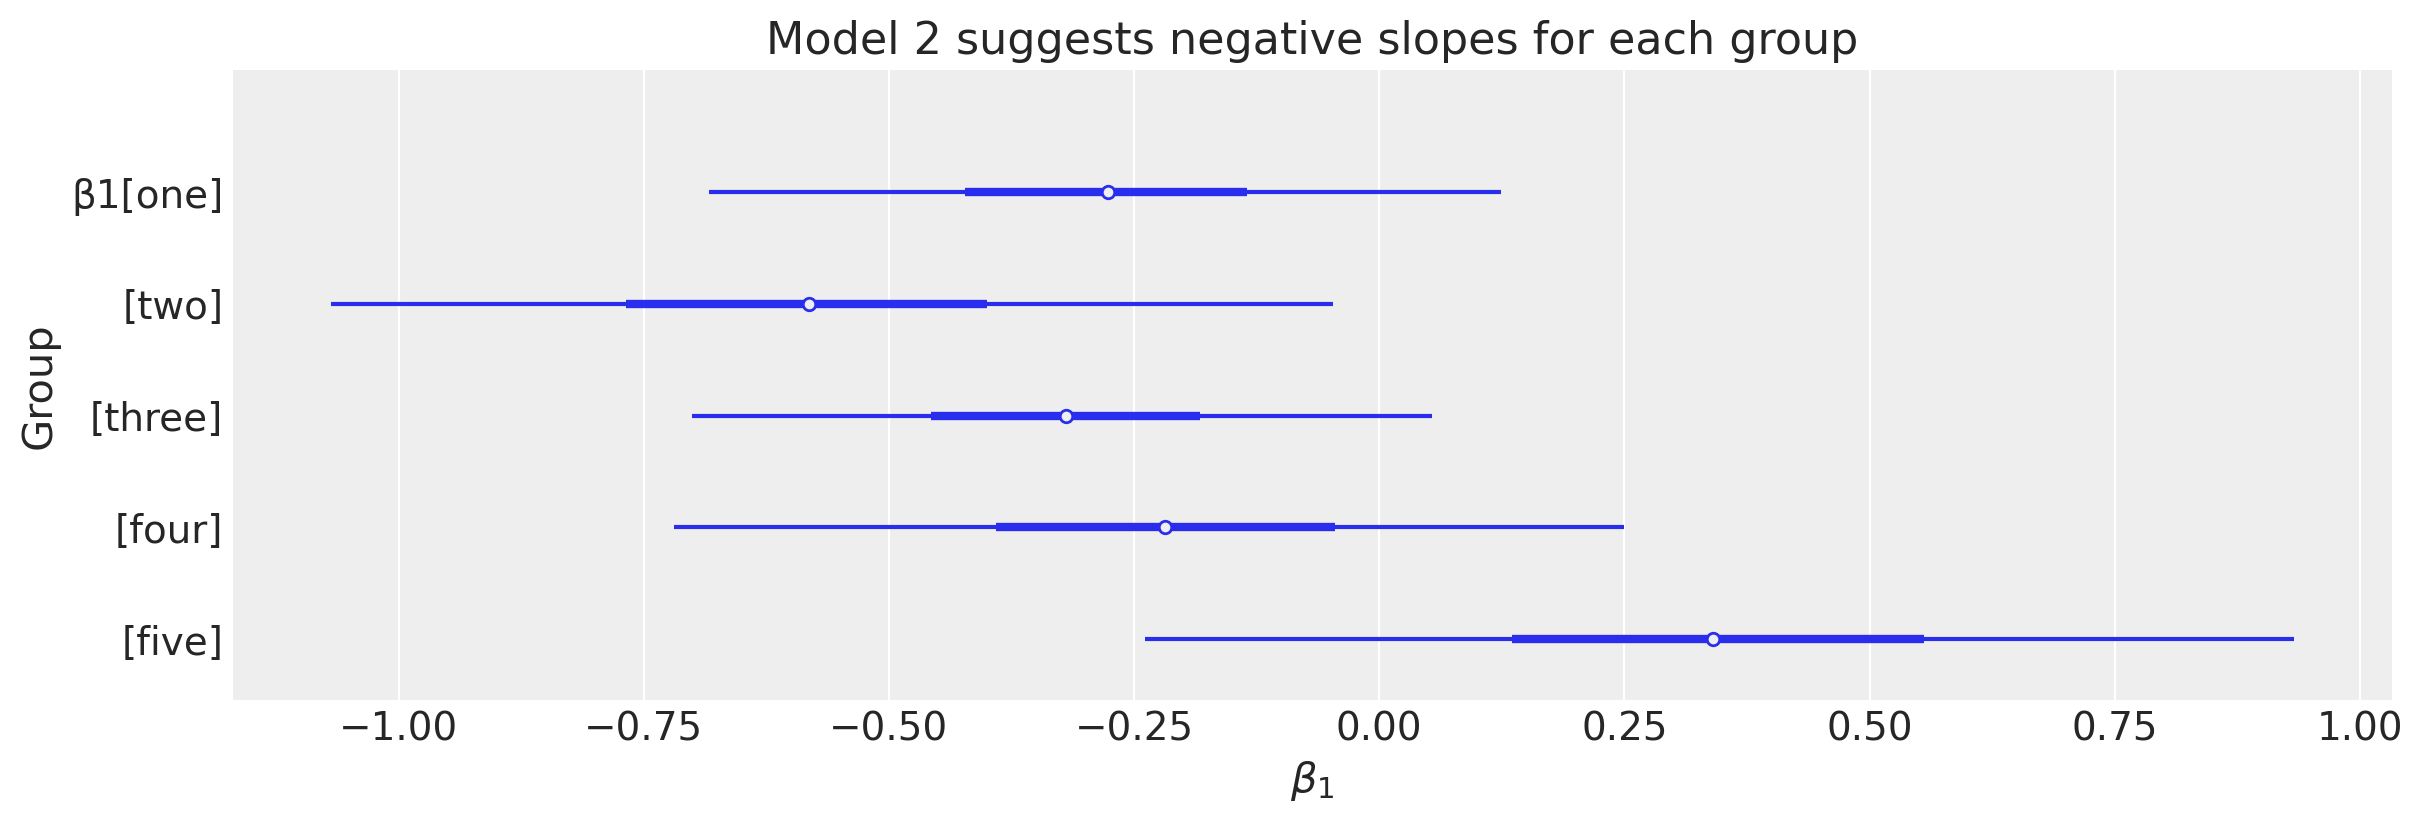

In [32]:
ax = az.plot_forest(idata2.posterior["β1"], combined=True, figsize=figsize)
ax[0].set(
    title="Model 2 suggests negative slopes for each group", xlabel=r"$\beta_1$", ylabel="Group"
);